In [39]:
from datasetsforecast.m5 import M5
from datasetsforecast.m4 import M4

import pandas as pd
import holidays

import seaborn as sb

import statsmodels.api as sm
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf

In [23]:
sb.set_theme(style="darkgrid")

### M5 Data
---
Data from Walmart, I think this is sales data on a per state level with some category.

In [24]:
df_M5, *_ = M5.load('./data')

n_series = 40
uids = df_M5['unique_id'].unique()[:n_series]
df = df_M5.query('unique_id in @uids').copy()

del df_M5

<Axes: xlabel='ds'>

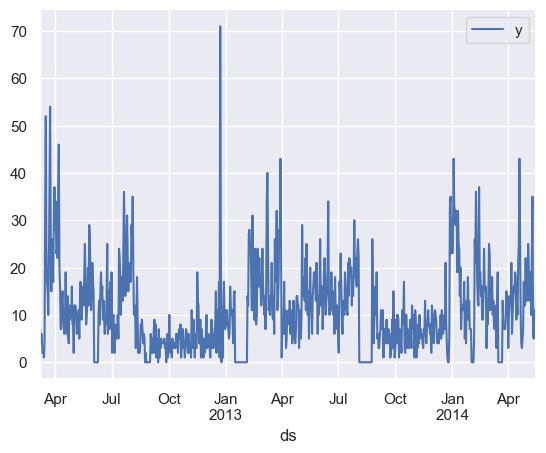

In [25]:
ds = df.query("unique_id == 'FOODS_1_004_CA_1'").iloc[:800]
ds.plot(x='ds', y='y')

In [26]:
mat = pd.DataFrame()

mat['y'] = ds['y']

### Linear Regression
---
Apparently regression can essentially do cyclic indicator variables. They're essentially indicator variables that don't require a piecewise formulation. 

A few timescales are used to learn on cyclic information.
- monthly
- quarterly
- yearly
- weekly

One thing we can do with daily information is to approximate the 31 term pattern with a fourier terms that only need the first few fourier terms to capture the pattern.

$$\cos\left(\frac{2\pi k}{n}\right)$$
$$\sin\left(\frac{2\pi k}{n}\right)$$

- $k$: The kth term.
- $n$: The total duration.

In [27]:
months = pd.get_dummies(ds['ds'].apply(lambda ts: ts.month), prefix='Month', drop_first=True, dtype=int)
quarters = pd.get_dummies(ds['ds'].apply(lambda ts: ts.quarter), prefix='Q', drop_first=True, dtype=int)
years = pd.get_dummies(ds['ds'].apply(lambda ts: ts.year), prefix='Year', drop_first=True, dtype=int)
weeks = pd.get_dummies(ds['ds'].apply(lambda ts: ts.week), prefix='Week', drop_first=True, dtype=int)

days = ds['ds'].apply(lambda ts: ts.day)

n_harmonics = 3
for k in range(1, n_harmonics + 1):
    step = 2 * np.pi * k * days / 30
    
    mat[f'Day_sin_{k}'] = np.sin(step)
    mat[f'Day_cos_{k}'] = np.cos(step)

us_holidays = holidays.US(years=ds['ds'].dt.year.unique().tolist())
mat['holiday'] = ds['ds'].apply(lambda x: x in us_holidays).astype(int)

mat = pd.concat([mat, weeks, months, quarters, years], axis=1)

In [28]:
mat_const = sm.add_constant(mat)
model = sm.OLS(mat_const['y'], mat_const.drop(columns=['y'])).fit()

In [29]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.348
Model:                            OLS   Adj. R-squared:                  0.285
Method:                 Least Squares   F-statistic:                     5.480
Date:                Wed, 14 Feb 2024   Prob (F-statistic):           2.61e-34
Time:                        20:00:15   Log-Likelihood:                -2720.6
No. Observations:                 800   AIC:                             5585.
Df Residuals:                     728   BIC:                             5922.
Df Model:                          71                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         17.8125      2.556      6.970      0.000      12.795      22.830
Day_sin_1     -0.3696      0.943     -0.392      0.695      -2.222       1.483
Day_cos_1      2.0597      0.916      2.248      0.025       0.261       3.859
Day_sin_2     -0.6658      0.530     -1.257      0.209      -1.705       0.374
Day_cos_2     -0.1979      0.519     -0.381      0.703      -1.218       0.822
Day_sin_3     -0.3661      0.417     -0.878      0.380      -1.184       0.452
Day_cos_3     -0.0356      0.422     -0.084      0.933      -0.865       0.793
holiday       -1.2523      1.793     -0.698      0.485      -4.773       2.268
Week_2         0.9209      3.320      0.277      0.782      -5.597       7.439
Week_3        -7.8386      3.493     -2.244      0.025     -14.697      -0.980
Week_4       -13.3012      3.413     -3.897      0.000     -20.003      -6.600
Week_5       -14.6663      3.483     -4.211      0.000     -21.505      -7.828
Week_6         5.0051      5.171      0.968      0.333      -5.147      15.158
Week_7         7.9472      5.364      1.482      0.139      -2.584      18.478
Week_8         3.4752      5.391      0.645      0.519      -7.108      14.058
Week_9        -1.4590      5.438     -0.268      0.789     -12.135       9.217
Week_10       -5.4188      6.544     -0.828      0.408     -18.266       7.429
Week_11       -4.5238      6.715     -0.674      0.501     -17.707       8.660
Week_12       -3.5929      6.802     -0.528      0.598     -16.947       9.762
Week_13       -2.3441      6.631     -0.354      0.724     -15.362      10.673
Week_14       -6.4948      7.632     -0.851      0.395     -21.479       8.489
Week_15      -10.6069      7.956     -1.333      0.183     -26.226       5.012
Week_16       -8.2839      8.064     -1.027      0.305     -24.115       7.548
Week_17      -15.1615      8.063     -1.880      0.060     -30.990       0.667
Week_18      -12.7035      7.993     -1.589      0.112     -28.396       2.989
Week_19       -9.2469      8.397     -1.101      0.271     -25.733       7.239
Week_20       -9.4223      8.572     -1.099      0.272     -26.252       7.407
Week_21       -9.6556      8.702     -1.110      0.268     -26.740       7.428
Week_22      -10.8885      8.427     -1.292      0.197     -27.432       5.655
Week_23      -15.1876      8.876     -1.711      0.087     -32.612       2.237
Week_24       -5.7455      9.069     -0.634      0.527     -23.550      12.059
Week_25      -10.1821      9.177     -1.109      0.268     -28.199       7.835
Week_26      -13.9761      8.985     -1.556      0.120     -31.615       3.663
Week_27      -15.5802      9.431     -1.652      0.099     -34.095       2.935
Week_28      -10.4681      9.576     -1.093      0.275     -29.269       8.332
Week_29       -4.1006      9.645     -0.425      0.671     -23.036      14.835
We

In [30]:
ds['fitted'] = model.fittedvalues
ds['resid'] = model.resid

mat['resid'] = model.resid

<Axes: xlabel='ds', ylabel='y'>

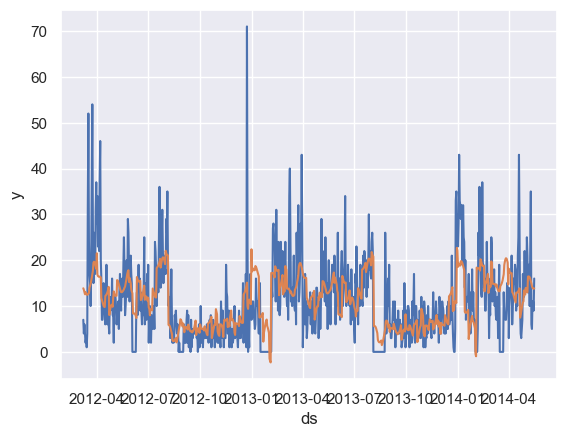

In [31]:
sb.lineplot(data=ds, x='ds', y='y')
sb.lineplot(data=ds, x='ds', y='fitted')

### Residuals
---
Difference between ground truth and prediction.

<Axes: xlabel='ds', ylabel='resid'>

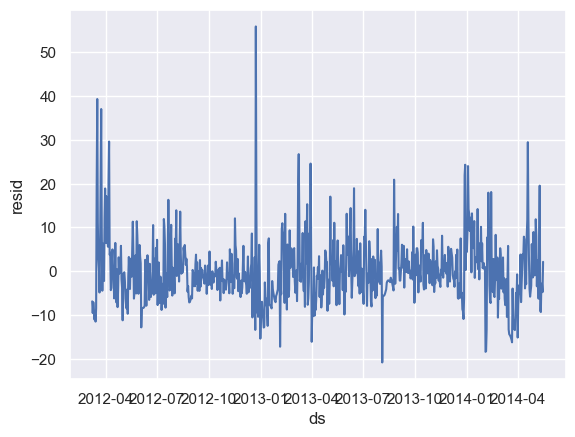

In [32]:
sb.lineplot(data=ds, x='ds', y='resid')

<Axes: xlabel='resid', ylabel='Count'>

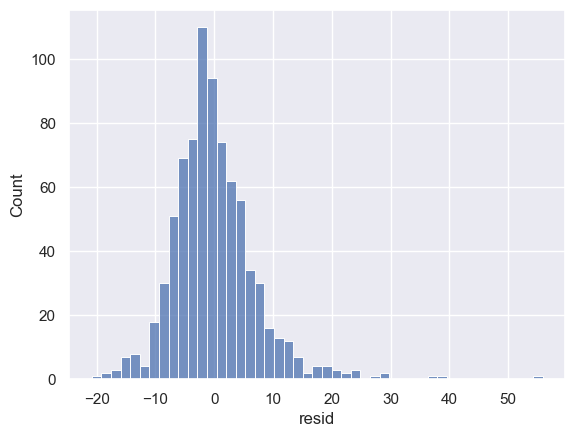

In [33]:
sb.histplot(data=ds, x='resid')

<Axes: xlabel='Day_sin_1', ylabel='resid'>

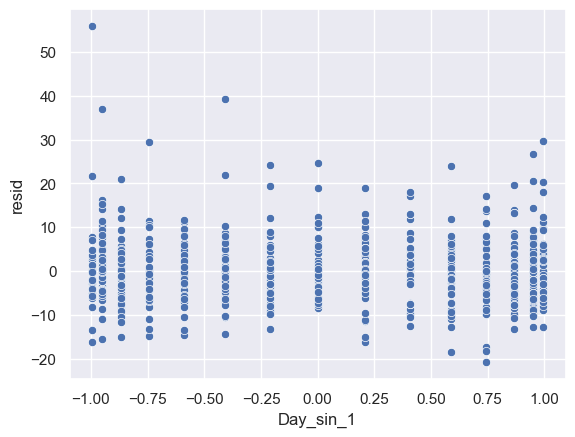

In [37]:
sb.scatterplot(data=mat, y='resid', x='Day_sin_1')

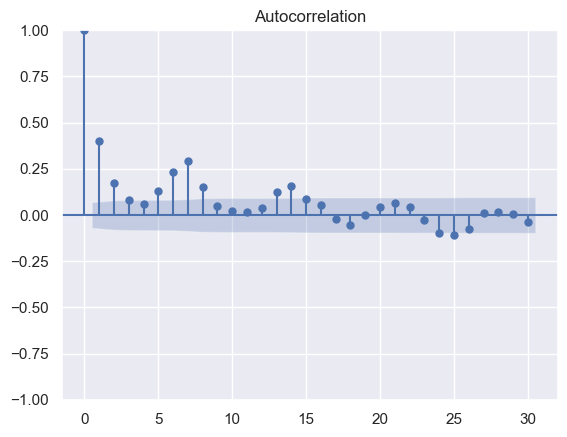

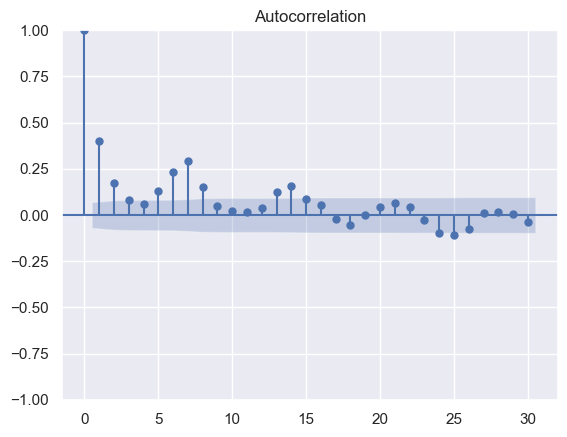

In [41]:
plot_acf(x=mat['resid'])